In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.model_selection import train_test_split
from joblib import dump, load
# ÏÇ¨Ï†Ñ ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò(XAIÏö©, XAI: Ïã§ÌòÑÍ∞ÄÎä•Ìïú AI) : pip install shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
# Ìè∞Ìä∏ÏßÄÏ†ï
plt.rcParams['font.family'] = 'Malgun Gothic'

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏ Íπ®Ïßê ÏßÄÏ†ï
plt.rcParams['axes.unicode_minus'] = False

# Ïà´ÏûêÍ∞Ä ÏßÄÏàòÌëúÌòÑÏãùÏúºÎ°ú ÎÇòÏò¨ Îïå ÏßÄÏ†ï
pd.options.display.float_format = '{:.2f}'.format

In [45]:
# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï∫êÏã±
@st.cache_data
def load_data():
    df = pd.read_csv('dataset/mental_health_wearable_data.csv', encoding='utf-8')
    df = df.rename(columns={'Mental_Health_Condition ': 'Mental_Health_Condition'})
    return df


df = load_data()
df.columns = df.columns.str.strip()
print(df.columns)

2025-03-25 08:56:05.932 No runtime found, using MemoryCacheStorageManager


Index(['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Physical_Activity_Steps',
       'Mood_Rating', 'Mental_Health_Condition'],
      dtype='object')


In [46]:
df.head()

Heart_Rate_BPM  Sleep_Duration_Hours  Physical_Activity_Steps  Mood_Rating  \
0              98                  7.43                    13760            5   
1             111                  9.46                    11455            9   
2              88                  4.04                     9174            8   
3              74                  8.86                    12612            1   
4             102                  9.69                     3923            9   

   Mental_Health_Condition  
0                        1  
1                        0  
2                        1  
3                        1  
4                        0

In [47]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
print("Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Ïπò ÌôïÏù∏:")
print(df.isnull().sum())

Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Ïπò ÌôïÏù∏:
Heart_Rate_BPM             0
Sleep_Duration_Hours       0
Physical_Activity_Steps    0
Mood_Rating                0
Mental_Health_Condition    0
dtype: int64


In [48]:
# Î∂àÌïÑÏöîÌïú Ïª¨Îüº Ï†úÍ±∞ (ÏõêÌï´ Ïù∏ÏΩîÎî© ÏóÜÏù¥ÎèÑ Ïûò ÏûëÎèôÌïòÎèÑÎ°ù)
df = df.drop(['Physical_Activity_Steps', 'Mood_Rating'], axis=1)

In [49]:
# Ï†ÑÏ≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print("Ï†ÑÏ≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:")
print("Îç∞Ïù¥ÌÑ∞:", df.shape)

Ï†ÑÏ≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:
Îç∞Ïù¥ÌÑ∞: (10000, 3)


In [50]:
# Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº ÌôïÏù∏
print("\nÎç∞Ïù¥ÌÑ∞ Ïª¨Îüº:", df.columns.tolist())


Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº: ['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Mental_Health_Condition']


In [51]:
# Ïä§ÏºÄÏùºÎßÅ : Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî - (MinMaxScaler)
scaler = MinMaxScaler()
X = df.drop('Mental_Health_Condition', axis=1)
y = df['Mental_Health_Condition']

In [52]:
# ÌîºÏ≤ò Ïàò ÌôïÏù∏
n_features = X.shape[1]
print(f"ÌîºÏ≤ò Ïàò: {n_features}")

ÌîºÏ≤ò Ïàò: 2


In [53]:
X = scaler.fit_transform(X)

In [54]:
# ÌäπÏÑ± Ïù¥Î¶Ñ Ï†ÄÏû• (SHAP ÏãúÍ∞ÅÌôîÏóê ÏÇ¨Ïö©)
feature_names = df.drop('Mental_Health_Condition', axis=1).columns.tolist()

In [55]:
# train, validation set Î∂ÑÎ¶¨
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Set (ÌïôÏäµ Îç∞Ïù¥ÌÑ∞) : Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ§Îäî Îç∞ ÏÇ¨Ïö©
# Validation Set (Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞) : ÌïôÏäµÎêú Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÍ≥†, ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãùÏóê ÏÇ¨Ïö©
# Test Set (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞) : ÏµúÏ¢Ö Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌôïÏù∏ÌïòÎäî Îç∞ ÏÇ¨Ïö© (Ïã§Ï†ú ÏòàÏ∏°Ïóê Í∞ÄÍπåÏõÄ)
# Î™®Îç∏Ïù¥ Í≥ºÏ†ÅÌï©ÌïòÏßÄ ÏïäÎèÑÎ°ù Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞(Validation Set)Î•º ÏÉùÏÑ±ÌïòÎäî Í≥ºÏ†ï
# Train SetÏóêÏÑú ÌïôÏäµÌïú Î™®Îç∏ÏùÑ Validation SetÏóêÏÑú ÌÖåÏä§Ìä∏Ìï¥Î≥¥Î©¥ÏÑú ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï∞æÍ≥†, Î™®Îç∏Ïùò ÏùºÎ∞òÌôî ÏÑ±Îä•ÏùÑ ÌèâÍ∞Ä


In [56]:
# Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú ÌôïÏù∏
print(f"X_train ÌòïÌÉú(reshape Ï†Ñ): {X_train.shape}")
print(f"X_val ÌòïÌÉú(reshape Ï†Ñ): {X_val.shape}")

X_train ÌòïÌÉú(reshape Ï†Ñ): (8000, 2)
X_val ÌòïÌÉú(reshape Ï†Ñ): (2000, 2)


In [57]:
# LSTM ÏûÖÎ†•ÏùÑ ÏúÑÌïú reshape (samples, time steps, features)
# LSTM ÏûÖÎ†•Ïóê ÎßûÍ≤å Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú Î≥ÄÍ≤Ω
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_val = X_val.reshape(X_val.shape[0], 1, n_features)

In [58]:
# reshape ÌõÑ ÌòïÌÉú ÌôïÏù∏
print(f"X_train ÌòïÌÉú(reshape ÌõÑ): {X_train.shape}")
print(f"X_val ÌòïÌÉú(reshape ÌõÑ): {X_val.shape}")

X_train ÌòïÌÉú(reshape ÌõÑ): (8000, 1, 2)
X_val ÌòïÌÉú(reshape ÌõÑ): (2000, 1, 2)


In [59]:
# 2. LSTM Î™®Îç∏ Íµ¨Ï∂ï(ÏÉùÏÑ±)
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Ï†ïÏã†Í±¥Í∞ïÏù¥ Ï¢ãÏùÑ Í∞ÄÎä•ÏÑ±Ïóê ÎåÄÌïú Ïù¥ÏßÑ Î∂ÑÎ•ò(1, 0)Ïù¥ÎØÄÎ°ú sigmoid ÏÇ¨Ïö©

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # binary_crossentropy : Ïù¥ÏßÑ Î∂ÑÎ•òÏóê ÏÇ¨Ïö© (ex. 0, 1 Îì±)

c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 1, 64)          ‚îÇ        17,152 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 1, 64)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_3 (LSTM)                   ‚îÇ (None, 32)             ‚îÇ        12,416 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Î™®Îç∏ Ïª¥ÌååÏùº
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
# Early Stopping - verbose=1Î°ú ÏÑ§Ï†ïÌïòÏó¨ ÏßÑÌñâÏÉÅÌô© ÌôïÏù∏
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # 10Î≤àÏùò ÏóêÌè≠ ÎèôÏïà Í∞úÏÑ†Ïù¥ ÏóÜÏúºÎ©¥ ÌïôÏäµ Ï§ëÎã®
    restore_best_weights=True,    #  Í∞ÄÏû• Ï¢ãÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥ÏòÄÎçò Î™®Îç∏Ïùò Í∞ÄÏ§ëÏπò(weights)Î•º Î≥µÏõê
    verbose=1             # Ï§ëÎã® Ïãú Î©îÏãúÏßÄ Ï∂úÎ†•
)

In [63]:
# 3. Î™®Îç∏ ÌõàÎ†® - verbose=1Î°ú ÏÑ§Ï†ïÌïòÏó¨ ÏßÑÌñâÏÉÅÌô© ÌôïÏù∏
epochs = 100
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1             # ÌõàÎ†® ÏßÑÌñâÏÉÅÌô© Ï∂úÎ†•
)

Epoch 1/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.5612 - loss: 0.2445 - val_accuracy: 0.6730 - val_loss: 0.2106
Epoch 2/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.6560 - loss: 0.2098 - val_accuracy: 0.6715 - val_loss: 0.2085
Epoch 3/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.6732 - loss: 0.2072 - val_accuracy: 0.6715 - val_loss: 0.2081
Epoch 4/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.6775 - loss: 0.2074 - val_accuracy: 0.6725 - val_loss: 0.2089
Epoch 5/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.6768 - loss: 0.2055 - val_accuracy: 0.6695 - val_loss: 0.2081
Epoch 6/100
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.6648 - loss: 0.2079 - val_accuracy: 0.6715 - val

In [64]:
# ÌïôÏäµÏù¥ Î™á Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú Î©àÏ∑ÑÎäîÏßÄ ÌôïÏù∏
actual_epochs = len(history.history['loss'])
print(f"ÌïôÏäµÏù¥ {actual_epochs}Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.")

ÌïôÏäµÏù¥ 23Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.


In [65]:
# 4. ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
# Validation set ÌèâÍ∞Ä
y_pred_val_proba = model.predict(X_val, verbose=0)

y_pred_val = (y_pred_val_proba > 0.5).astype(int)    # 0.5Î•º Í∏∞Ï§ÄÏúºÎ°ú Î∂ÑÎ•ò, astype(int) : TrueÎäî 1Î°ú, FalseÎäî 0

In [66]:
# ROC Curve Î∞è AUC Í≥ÑÏÇ∞ (Validation set)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

In [67]:
# Confusion Matrix (Validation set)
cm = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation Set):\n", cm)

Confusion Matrix (Validation Set):
 [[631 341]
 [318 710]]


In [68]:
# Classification Report (Validation set)
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_pred_val))


Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.66      0.65      0.66       972
           1       0.68      0.69      0.68      1028

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



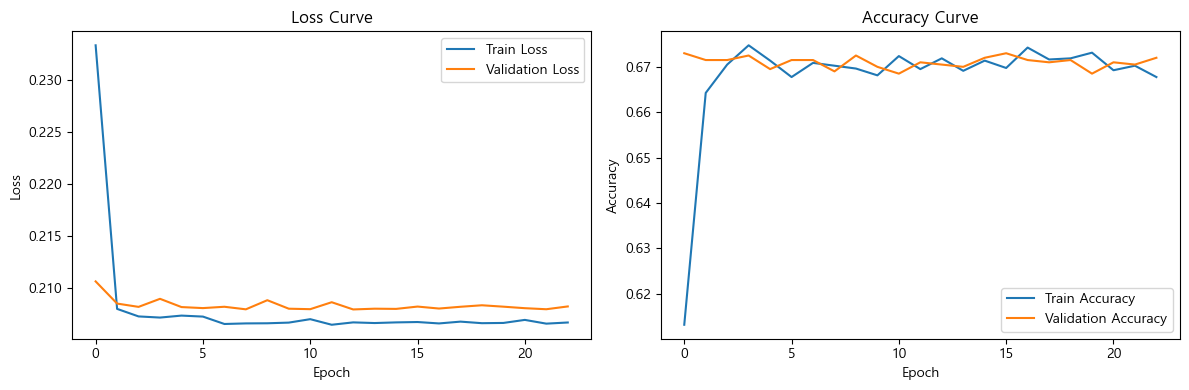

In [69]:
# 5. Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è ÌÜµÍ≥Ñ Î∂ÑÏÑù
# ÌïôÏäµ Í≥°ÏÑ†(Í≥ºÏ†ï) ÏãúÍ∞ÅÌôî (loss, accuracy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

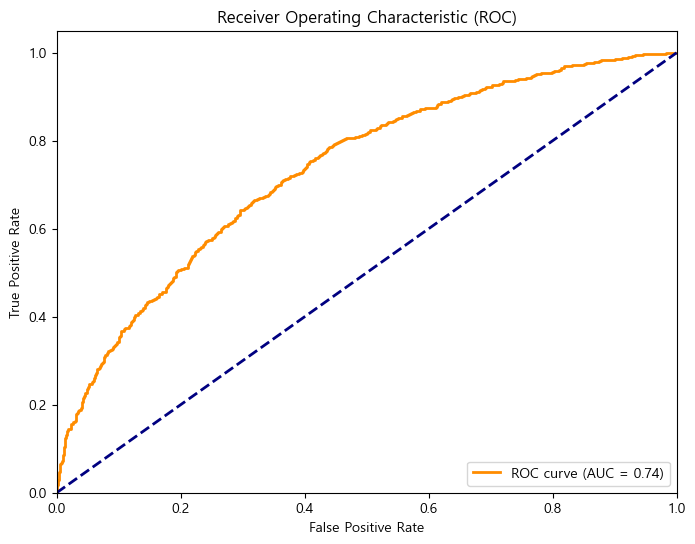

In [70]:
# ROC Curve ÏãúÍ∞ÅÌôî (Validation set)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

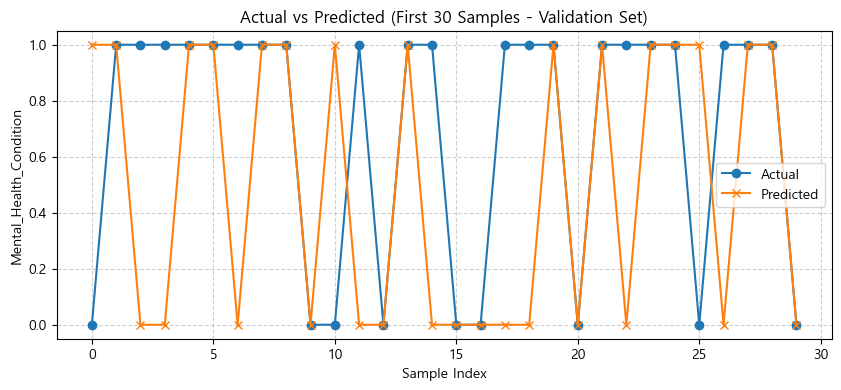

In [71]:
# Ïã§Ï†úÍ∞í vs ÏòàÏ∏°Í∞í ÏãúÍ∞ÅÌôî (Validation set - Ï≤òÏùå 30Í∞ú ÏÉòÌîå)
plt.figure(figsize=(10, 4))
plt.plot(y_val[:30].values, label='Actual', marker='o')
plt.plot(y_pred_val[:30].flatten(), label='Predicted', marker='x')  # flatten() Ï∂îÍ∞Ä
plt.title('Actual vs Predicted (First 30 Samples - Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Mental_Health_Condition')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.show()

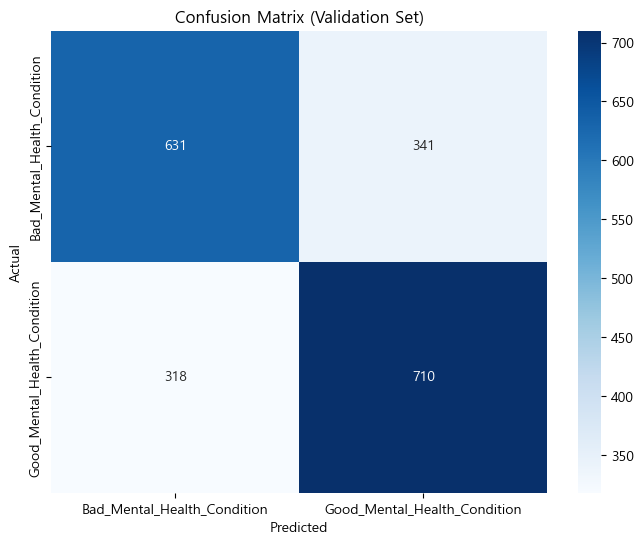

In [72]:
# Confusion Matrix ÏãúÍ∞ÅÌôî (Validation set)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad_Mental_Health_Condition', 'Good_Mental_Health_Condition'], yticklabels=['Bad_Mental_Health_Condition', 'Good_Mental_Health_Condition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()
# üîç ÌòºÎèôÌñâÎ†¨ Î∂ÑÏÑù (ÎÇ¥Í∞Ä Ï∂úÎ†•Ìïú Í∑∏ÎûòÌîÑ ÏùòÎØ∏ Ìï¥ÏÑù)
# 1Ô∏è‚É£ Ï¥ù 2000Í∞úÏùò Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Ï§ë Î™®Îç∏Ïù¥ 1339Í±¥ÏùÑ Ï†ïÌôïÌûà ÏòàÏ∏°Ìï® (633 + 706).
# 2Ô∏è‚É£ 633Í±¥ÏùÄ Ïã§Ï†úÎ°ú "Bad Mental Health"Ïù¥Í≥†, Î™®Îç∏ÎèÑ Ï†ïÌôïÌûà "Bad"ÎùºÍ≥† ÏòàÏ∏° (TN).
# 3Ô∏è‚É£ 706Í±¥ÏùÄ Ïã§Ï†úÎ°ú "Good Mental Health"Ïù¥Í≥†, Î™®Îç∏ÎèÑ Ï†ïÌôïÌûà "Good"Ïù¥ÎùºÍ≥† ÏòàÏ∏° (TP).
# 4Ô∏è‚É£ 339Í±¥ÏùÄ Ïã§Ï†úÎ°ú "Bad Mental Health"Ïù∏Îç∞, Î™®Îç∏Ïù¥ "Good Mental Health"Î°ú ÏûòÎ™ª ÏòàÏ∏° (FP, Í±∞Ïßì ÏñëÏÑ±).
# 5Ô∏è‚É£ 322Í±¥ÏùÄ Ïã§Ï†úÎ°ú "Good Mental Health"Ïù∏Îç∞, Î™®Îç∏Ïù¥ "Bad Mental Health"Î°ú ÏûòÎ™ª ÏòàÏ∏° (FN, Í±∞Ïßì ÏùåÏÑ±).

# ‚úî Î™®Îç∏Ïù¥ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïñ¥Îäê Ï†ïÎèÑ Ï†ïÌôïÌïòÍ≤å ÏûëÎèôÌïòÏßÄÎßå, FPÏôÄ FNÏù¥ Ï°¥Ïû¨ÌïòÏó¨ Í∞úÏÑ†Ïù¥ ÌïÑÏöîÌï®! 

In [74]:
# Î™®Îç∏ Ï†ÄÏû• (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
model.save('model/rnn_LSTM_pred_mentalHealth.h5')
print("Î™®Îç∏Ïù¥ 'trnn_LSTM_pred_mentalHealth.h5' ÌååÏùºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

Î™®Îç∏Ïù¥ 'trnn_LSTM_pred_mentalHealth.h5' ÌååÏùºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


C:\Users\yj\AppData\Local\Temp\ipykernel_24036\1744047028.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Mental_Health_Condition', data=df, palette='viridis')


Text(0, 0.5, 'Ïù∏Ïõê Ïàò')

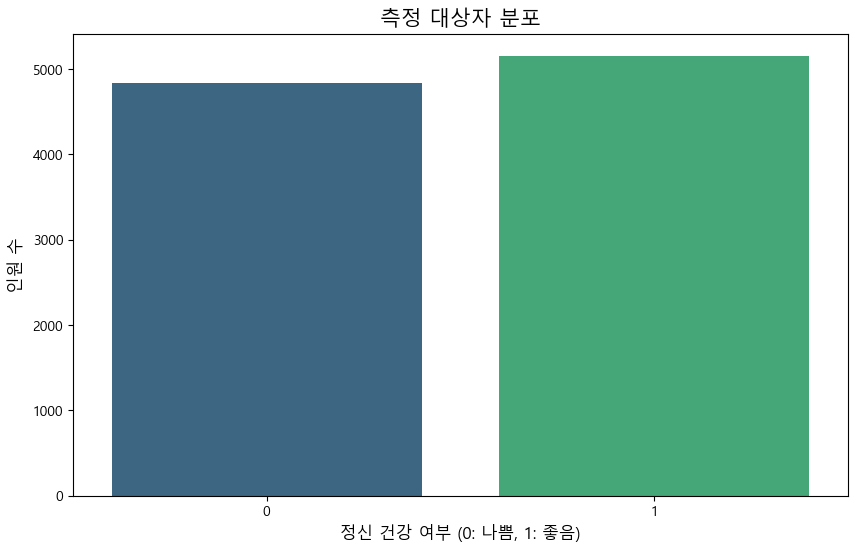

In [78]:
# ÏÉùÏ°¥Ïûê Î∂ÑÌè¨ ÌôïÏù∏
plt.figure(figsize=(10, 6))
sns.countplot(x='Mental_Health_Condition', data=df, palette='viridis')
plt.title('Ï∏°Ï†ï ÎåÄÏÉÅÏûê Î∂ÑÌè¨', fontsize=15)
plt.xlabel('Ï†ïÏã† Í±¥Í∞ï Ïó¨Î∂Ä (0: ÎÇòÏÅ®, 1: Ï¢ãÏùå)', fontsize=12)
plt.ylabel('Ïù∏Ïõê Ïàò', fontsize=12)

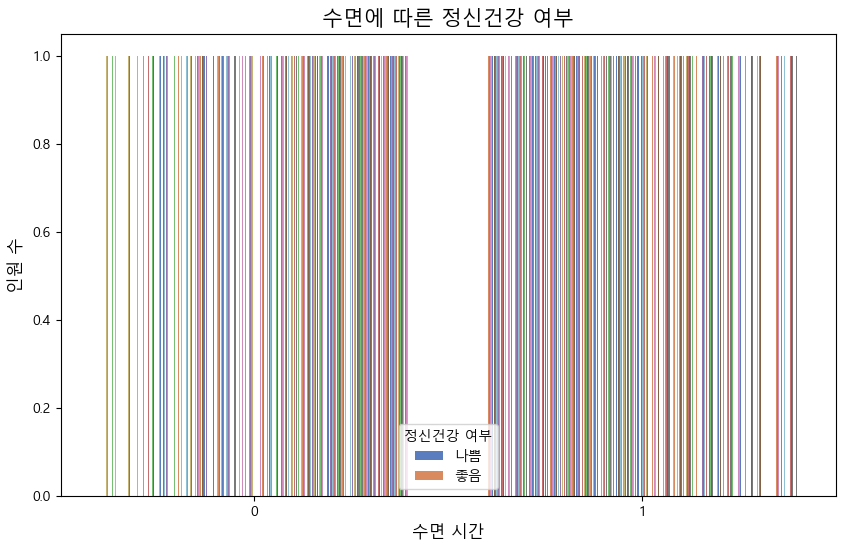

In [80]:
# ÏàòÎ©¥Í≥º Ï†ïÏã†Í±¥Í∞ï Í¥ÄÍ≥Ñ
plt.figure(figsize=(10, 6))
sns.countplot(x='Mental_Health_Condition', hue='Sleep_Duration_Hours', data=df, palette='muted')
plt.title('ÏàòÎ©¥Ïóê Îî∞Î•∏ Ï†ïÏã†Í±¥Í∞ï Ïó¨Î∂Ä', fontsize=15)
plt.xlabel('ÏàòÎ©¥ ÏãúÍ∞Ñ', fontsize=12)
plt.ylabel('Ïù∏Ïõê Ïàò', fontsize=12)
plt.legend(title='Ï†ïÏã†Í±¥Í∞ï Ïó¨Î∂Ä', labels=['ÎÇòÏÅ®', 'Ï¢ãÏùå'])